In [127]:
import sympy as sp
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt

In [148]:
def normalize_expression(expr):
    expr = sp.simplify(expr)
    
    # Step 1: Expand expression to apply distributivity (e.g., 2*(x + y) -> 2*x + 2*y)
    expr = sp.expand(expr)

    # Step 2: Handle division (x / y => x * y^(-1))
    expr = expr.replace(
        lambda x: isinstance(x, sp.Pow) and x.exp == -1,
        lambda x: sp.Pow(x.base, -1, evaluate=False)
    )

    expr = expr.replace(
        lambda x: isinstance(x, sp.Mul),
        lambda x: sp.Mul(*x.args, evaluate=False)
    )

    expr = expr.replace(
        lambda x: isinstance(x, sp.Add),
        lambda x: sp.Add(*x.args, evaluate=False)
    )

    # Step 3: Rewrite subtraction (a - b => a + (-1)*b)
    expr = expr.replace(
        lambda x: isinstance(x, sp.Add) and any(isinstance(arg, sp.Mul) and -1 in arg.args for arg in x.args),
        lambda x: sp.Add(*x.args, evaluate=False)
    )

    return expr

In [149]:
class ExpressionGraphBuilder:
    def __init__(self):
        self.graph = nx.DiGraph()
        self.node_counter = 0
        self.node_map = {}

    def add_node(self, label):
        node_id = f"{label}_{self.node_counter}"
        self.graph.add_node(node_id, label=label)
        self.node_counter += 1
        return node_id

    def build(self, expr):
        expr = normalize_expression(expr)
        return self._build_node(expr)

    def _build_node(self, expr):
        if expr in self.node_map:
            return self.node_map[expr]

        if isinstance(expr, sp.Symbol):
            node = self.add_node("Sym:" + str(expr))
            self.node_map[expr] = node
            return node

        elif isinstance(expr, sp.Number):
            node = self.add_node("Num:" + str(expr))
            self.node_map[expr] = node
            return node

        elif isinstance(expr, sp.Add):
            root = self.add_node("Add")
            for arg in expr.args:
                child = self._build_node(arg)
                self.graph.add_edge(root, child)
            return root

        elif isinstance(expr, sp.Mul):
            root = self.add_node("Mul")
            for arg in expr.args:
                child = self._build_node(arg)
                self.graph.add_edge(root, child)
            return root

        elif isinstance(expr, sp.Pow):
            root = self.add_node("Pow")
            base = self._build_node(expr.base)
            exp = self._build_node(expr.exp)
            self.graph.add_edge(root, base, role="base")
            self.graph.add_edge(root, exp, role="exp")
            return root

        elif isinstance(expr, sp.Function):
            func_name = expr.func.__name__
            root = self.add_node(func_name.capitalize())  # e.g., Log, Exp
            for arg in expr.args:
                child = self._build_node(arg)
                self.graph.add_edge(root, child)
            return root

        else:
            raise NotImplementedError(f"Unsupported type: {type(expr)}")

    def get_graph(self):
        return self.graph


In [150]:
# --- Compare two expressions for symbolic equality ---
def expressions_are_equal(expr1, expr2):
    builder1 = ExpressionGraphBuilder()
    builder1.build(expr1)
    g1 = builder1.get_graph()

    builder2 = ExpressionGraphBuilder()
    builder2.build(expr2)
    g2 = builder2.get_graph()

    def node_match(n1, n2):
        return n1['label'] == n2['label']

    def edge_match(e1, e2):
        return e1.get('role', None) == e2.get('role', None)

    matcher = nx.isomorphism.DiGraphMatcher(g1, g2, node_match=node_match, edge_match=edge_match)
    return matcher.is_isomorphic()

In [151]:
import networkx as nx

def ged_symbolic_distance(expr1, expr2, use_graph=True):
    # Algebraic simplification
    diff = sp.simplify(expr1 - expr2)
    if diff == 0:
        return 0  # Perfect match

    # Optionally use expression tree graph edit distance
    if use_graph:
        builder1 = ExpressionGraphBuilder()
        builder1.build(expr1)
        g1 = builder1.get_graph()

        builder2 = ExpressionGraphBuilder()
        builder2.build(expr2)
        g2 = builder2.get_graph()

        try:
            ged = nx.graph_edit_distance(g1, g2)
            return ged
        except Exception:
            return float('inf')  # fallback in case of failure

    # Fallback: use size of simplified difference as a proxy for distance
    return sp.count_ops(diff, visual=False)

In [152]:
def symbolic_distance_with_constants(expr1, expr2):
    builder1 = ExpressionGraphBuilder()
    builder1.build(expr1)
    g1 = builder1.get_graph()

    builder2 = ExpressionGraphBuilder()
    builder2.build(expr2)
    g2 = builder2.get_graph()

    def parse_node_label(label):
        if label.startswith("Num:"):
            try:
                return float(label.split(":")[1])
            except:
                return None
        return label

    def soft_node_match(n1, n2):
        l1, l2 = n1["label"], n2["label"]
        if l1.startswith("Num:") and l2.startswith("Num:"):
            v1, v2 = parse_node_label(l1), parse_node_label(l2)
            return abs(v1 - v2) < 0.05  # Adjustable tolerance
        return l1 == l2

    def edge_match(e1, e2):
        return e1.get("role", None) == e2.get("role", None)

    try:
        dist = nx.graph_edit_distance(g1, g2, node_match=soft_node_match, edge_match=edge_match)
        return round(dist, 4) if dist is not None else float("inf")
    except Exception as e:
        print("Error computing distance:", e)
        return float("inf")


In [153]:
def jaccard_symbolic_distance(expr1, expr2):
    builder1 = ExpressionGraphBuilder()
    builder1.build(expr1)
    g1 = builder1.get_graph()

    builder2 = ExpressionGraphBuilder()
    builder2.build(expr2)
    g2 = builder2.get_graph()

    # Fast equality check
    if nx.is_isomorphic(
        g1, g2,
        node_match=lambda x, y: x["label"] == y["label"],
        edge_match=lambda x, y: x.get("role", None) == y.get("role", None)
    ):
        return 0.0

    # Compute soft Jaccard-like distance over graph edge signatures
    def graph_signature(g):
        return set((u, d.get("role", "default"), v) for u, v, d in g.edges(data=True))

    s1 = graph_signature(g1)
    s2 = graph_signature(g2)

    intersection = len(s1.intersection(s2))
    union = len(s1.union(s2))

    jaccard_distance = 1 - (intersection / union) if union else 1.0

    return round(jaccard_distance, 4)


In [7]:
# --- Example usage ---
if __name__ == "__main__":
    x, y = sp.symbols('x y')

    expr1 = sp.sympify("x + x + y")
    expr2 = sp.sympify("2*x + y")
    expr3 = sp.sympify("x + y + x")

    print("expr1 == expr2:", expressions_are_equal(expr1, expr2))  # True
    print("expr1 == expr3:", expressions_are_equal(expr1, expr3))  # True

    expr4 = sp.sympify("x - 2")
    expr5 = sp.sympify("2 - x")
    print("x - 2 == 2 - x:", expressions_are_equal(expr4, expr5))  # False

    expr6 = sp.sympify("x**2")
    expr7 = sp.sympify("2**x")
    print("x**2 == 2**x:", expressions_are_equal(expr6, expr7))  # False
    

expr8 = sp.sympify("x*(a+b+c)")
expr9 = sp.sympify("a*x + x*b + x*c + c*x - x*c")
print(expressions_are_equal(expr8, expr9))


x, a, b = sp.symbols('x a b')
expr1 = sp.sympify("x*(a + b)")
expr2 = sp.sympify("a*x + x*b - b*x + x*b")
print(symbolic_distance(expr1, expr2))  # Should return 0

q1, q2, r = sp.symbols('q1 q2 r')
e1 = sp.sympify("(q1*q2)*(r**-1)")
e2 = sp.sympify("(q2*q1)*(r**-1)")
print(symbolic_distance(e1, e2))

q1, q2, r = sp.symbols('q1 q2 r')
e1 = sp.sympify("5.0*(q1*q2)*((r**2)**-1)")
e2 = sp.sympify("4.99*(q2*q1)*((r**2)**-1)")
print(jaccard_symbolic_distance(e1, e2))

a, b, c = sp.symbols('a b c')
e1 = sp.sympify("5*a*(b+c)")
e2 = sp.sympify("4.99*((b*a)+(a*c))")
e3 = sp.sympify("-0.01*(a+c)")
print(jaccard_symbolic_distance(e1, e2)) 
print(jaccard_symbolic_distance(e1, e3)) 
print(ged_symbolic_distance(e1, e3)) 
print(ged_symbolic_distance(e1, e2))

x1, x2, x3 = sp.symbols('x1 x2 x3')
e1 = sp.sympify("2.00*(x1 + (x2*x3))")
e2 = sp.sympify("1.68*((x3*x2) + x1)")

print(symbolic_distance_with_constants(e1, e2))

expr1 == expr2: True
expr1 == expr3: True
x - 2 == 2 - x: False
x**2 == 2**x: False


# GED between true and learned expr.

**Graph Edit Distance: A simulated example**

**True Symbolic Expression: (x1 + x2) x x3**

In [98]:
x1, x2, x3 = sp.symbols('x1 x2 x3')
true_expr = sp.sympify("(x1 + x2) * x3")

**Table 1 in the paper**

In [105]:
## Top r-ranked (r = 1, 2, 3) symbolic expressions obtained from HierBOSSS(K=2), based on maximum JMP

print('GED between true expression and HierBOSSS(K=2) learned expression based on maximum JMP!')

## r = 1
## considering the two trees together, as the true expression is learned using both T1 and T2
HierBOSSS_expr_r1_JMP =  sp.sympify("x3*x2 + x1*x3")
ged_r1_JMP = ged_symbolic_distance(true_expr, HierBOSSS_expr_r1_JMP)
print("combined GED for r=1: ", ged_r1_JMP)

## r = 2
## considering the two trees together, as the true expression is learned using both T1 and T2
HierBOSSS_expr_r2_JMP = sp.sympify("x3*x1 + x2*x3")
ged_r2_JMP = ged_symbolic_distance(true_expr, HierBOSSS_expr_r2_JMP)
print("combined GED for r=2: ", ged_r2_JMP)

## r = 3
## considering the minimum GED, i.e., min(GED(T, T1), GED(T, T2))
HierBOSSS_expr_r3_JMP = sp.sympify("(x2 + x1) * x3")
ged_r3_JMP = ged_symbolic_distance(true_expr, HierBOSSS_expr_r3_JMP)
print("min. GED for r=3: ", ged_r3_JMP)

GED between true expression and HierBOSSS(K=2) learned expression based on maximum JMP!
combined GED for r=1:  0
combined GED for r=2:  0
min. GED for r=3:  0


In [108]:
## Top r-ranked (r = 1, 2, 3) symbolic expressions obtained from HierBOSSS(K=2), based on maximum marginal lik.

print('GED between true expression and HierBOSSS(K=2) learned expression based on maximum Marg. Lik!')

## r = 1
## considering the minimum GED, i.e., min(GED(T, T1), GED(T, T2))
HierBOSSS_expr_r1_Marg_Lik_T1 = sp.sympify("x3 * (x2 + x1)")
HierBOSSS_expr_r1_Marg_Lik_T2 = sp.sympify("x3 * (x1 + x2)")
ged_r1_Marg_Lik_T1 = ged_symbolic_distance(true_expr, HierBOSSS_expr_r1_Marg_Lik_T1)
ged_r1_Marg_Lik_T2 = ged_symbolic_distance(true_expr, HierBOSSS_expr_r1_Marg_Lik_T2)
print("min. GED for r=1: ", min(ged_r1_Marg_Lik_T1, ged_r1_Marg_Lik_T2))

## r = 2
## considering the minimum GED, i.e., min(GED(T, T1), GED(T, T2))
HierBOSSS_expr_r2_Marg_Lik_T1 = sp.sympify("(x1 + x2) * x3")
ged_r2_Marg_Lik_T1 = ged_symbolic_distance(true_expr, HierBOSSS_expr_r2_Marg_Lik_T1)
print("min. GED for r=2: ", ged_r2_Marg_Lik_T1)

## r = 3
## considering the minimum GED, i.e., min(GED(T, T1), GED(T, T2))
HierBOSSS_expr_r3_Marg_Lik_T1 = sp.sympify("(x1 + x2) * x3")
ged_r3_Marg_Lik_T1 = ged_symbolic_distance(true_expr, HierBOSSS_expr_r3_Marg_Lik_T1)
print("min. GED for r=3: ", ged_r3_Marg_Lik_T1)

GED between true expression and HierBOSSS(K=2) learned expression based on maximum Marg. Lik!
min. GED for r=1:  0
min. GED for r=2:  0
min. GED for r=3:  0


**Table 6 in the paper, Appendix B.1**

In [155]:
BSR_T1 = sp.sympify("(x2+x1)*x3")
BSR_T2 = sp.sympify("(x3*x3) + (x3*x3)")
iBART_T1 = sp.sympify("(x2*x3)**0.5 + log(x1*x3)")
iBART_T2 = sp.sympify("(x2*x3)**0.5 * (x1*x3)")
QLattice_T = sp.sympify("(x1+x2)*x3")

print("min. GED for BSR: min. of",ged_symbolic_distance(true_expr, BSR_T1), "and", ged_symbolic_distance(true_expr, BSR_T2))
print("min. GED for iBART: min. of",ged_symbolic_distance(true_expr, iBART_T1), "and", ged_symbolic_distance(true_expr, iBART_T2))
print("GED for QLattice:", ged_symbolic_distance(true_expr, QLattice_T))

min. GED for BSR: min. of 0 and 6.0
min. GED for iBART: min. of 8.0 and 4.0
GED for QLattice: 0


**25 replications of the data, and each time reporting min(GED(T, T_i)), i=1,2 using HierBOSSS(K=2)**

In [171]:
# d=1
HierBOSSS_d1_T1 = sp.sympify("(x2+x1)*x3")
HierBOSSS_d1_T2 = sp.sympify("x1+x1")

# d=2
HierBOSSS_d2_T1 = sp.sympify("x3*(x2+x1)")
HierBOSSS_d2_T2 = sp.sympify("x1+x1")

# d=3
HierBOSSS_d3_T1 = sp.sympify("x2*x3 + x1*x3")
HierBOSSS_d3_T2 = sp.sympify("x1+x1")

# d=4
HierBOSSS_d4_T_combined = sp.sympify("x1*x3 + x2*x3")

# d=5
HierBOSSS_d5_T1 = sp.sympify("x3*x1 + x2*x3")
HierBOSSS_d5_T2 = sp.sympify("x3+x3")

# d=6
HierBOSSS_d6_T_combined = sp.sympify("x2*x3 + x1*x3")

# d=7
HierBOSSS_d7_T_combined = sp.sympify("x3*x1 + x2*x3")

# d=8
HierBOSSS_d8_T1 = sp.sympify("x2+x2")
HierBOSSS_d8_T2 = sp.sympify("(x1+x2)*x3")

# d=9
HierBOSSS_d9_T1 = sp.sympify("x1+x1")
HierBOSSS_d9_T2 = sp.sympify("x3*x2 + x1*x3")

# d=10
HierBOSSS_d10_T1 = sp.sympify("(x2+x1)*x3")
HierBOSSS_d10_T2 = sp.sympify("x2+x2")

# d=11
HierBOSSS_d11_T_combined = sp.sympify("x1*x3 + x2*x3")

# d=12
HierBOSSS_d12_T1 = sp.sympify("x3+x3")
HierBOSSS_d12_T2 = sp.sympify("x3*(x1+x2)")

# d=13
HierBOSSS_d13_T_combined = sp.sympify("x2*x3 + x1*x3")

# d=14
HierBOSSS_d14_T1 = sp.sympify("x1+x1")
HierBOSSS_d14_T2 = sp.sympify("x2*x3 + x1*x3")

# d=15
HierBOSSS_d15_T1 = sp.sympify("x1+x1")
HierBOSSS_d15_T2 = sp.sympify("x3*(x2+x1)")

# d=16
HierBOSSS_d16_T1 = sp.sympify("(x1+x2)*x3")
HierBOSSS_d16_T2 = sp.sympify("x1+x1")

# d=17
HierBOSSS_d17_T1 = sp.sympify("x1+x1")
HierBOSSS_d17_T2 = sp.sympify("x3*(x1+x2)")

# d=18
HierBOSSS_d18_T_combined = sp.sympify("x2*x3 + x1*x3")

# d=19
HierBOSSS_d19_T1 = sp.sympify("x2+x2")
HierBOSSS_d19_T2 = sp.sympify("x3*(x2+x1)")

# d=20
HierBOSSS_d20_T1 = sp.sympify("(x2+x1)*x3")
HierBOSSS_d20_T2 = sp.sympify("x3+x3")

# d=21
HierBOSSS_d21_T_combined = sp.sympify("x2*x3 + x3*x1")

# d=22
HierBOSSS_d22_T1 = sp.sympify("(x2+x1)*x3")
HierBOSSS_d22_T2 = sp.sympify("x3+x3")

# d=23
HierBOSSS_d23_T1 = sp.sympify("x3+x3")
HierBOSSS_d23_T2 = sp.sympify("x3*(x2+x1)")

# d=24
HierBOSSS_d24_T1 = sp.sympify("x2+x2")
HierBOSSS_d24_T2 = sp.sympify("x1*x3+x2*x3")

# d=25
HierBOSSS_d25_T1 = sp.sympify("x2+x2")
HierBOSSS_d25_T2 = sp.sympify("x3*(x1+x2)")

In [172]:
ged_d1 = min(ged_symbolic_distance(true_expr, HierBOSSS_d1_T1), ged_symbolic_distance(true_expr, HierBOSSS_d1_T2))
print("For d=1:", ged_d1)
ged_d2 = min(ged_symbolic_distance(true_expr, HierBOSSS_d2_T1), ged_symbolic_distance(true_expr, HierBOSSS_d2_T2))
print("For d=2:", ged_d2)
ged_d3 = min(ged_symbolic_distance(true_expr, HierBOSSS_d3_T1), ged_symbolic_distance(true_expr, HierBOSSS_d3_T2))
print("For d=3:", ged_d3)
ged_d4 = ged_symbolic_distance(true_expr, HierBOSSS_d4_T_combined)
print("For d=4:", ged_d4)
ged_d5 = min(ged_symbolic_distance(true_expr, HierBOSSS_d5_T1), ged_symbolic_distance(true_expr, HierBOSSS_d5_T2))
print("For d=5:", ged_d5)
ged_d6 = ged_symbolic_distance(true_expr, HierBOSSS_d6_T_combined)
print("For d=6:", ged_d6)
ged_d7 = ged_symbolic_distance(true_expr, HierBOSSS_d7_T_combined)
print("For d=7:", ged_d7)
ged_d8 = min(ged_symbolic_distance(true_expr, HierBOSSS_d8_T1), ged_symbolic_distance(true_expr, HierBOSSS_d8_T2))
print("For d=8:", ged_d8)
ged_d9 = min(ged_symbolic_distance(true_expr, HierBOSSS_d9_T1), ged_symbolic_distance(true_expr, HierBOSSS_d9_T2))
print("For d=9:", ged_d9)
ged_d10 = min(ged_symbolic_distance(true_expr, HierBOSSS_d10_T1), ged_symbolic_distance(true_expr, HierBOSSS_d10_T2))
print("For d=10:", ged_d10)
ged_d11 = ged_symbolic_distance(true_expr, HierBOSSS_d11_T_combined)
print("For d=11:", ged_d11)
ged_d12 = min(ged_symbolic_distance(true_expr, HierBOSSS_d12_T1), ged_symbolic_distance(true_expr, HierBOSSS_d12_T2))
print("For d=12:", ged_d12)
ged_d13 = ged_symbolic_distance(true_expr, HierBOSSS_d13_T_combined)
print("For d=13:", ged_d13)
ged_d14 = min(ged_symbolic_distance(true_expr, HierBOSSS_d14_T1), ged_symbolic_distance(true_expr, HierBOSSS_d14_T2))
print("For d=14:", ged_d14)
ged_d15 = min(ged_symbolic_distance(true_expr, HierBOSSS_d15_T1), ged_symbolic_distance(true_expr, HierBOSSS_d15_T2))
print("For d=15:", ged_d15)
ged_d16 = min(ged_symbolic_distance(true_expr, HierBOSSS_d16_T1), ged_symbolic_distance(true_expr, HierBOSSS_d16_T2))
print("For d=16:", ged_d16)
ged_d17 = min(ged_symbolic_distance(true_expr, HierBOSSS_d17_T1), ged_symbolic_distance(true_expr, HierBOSSS_d17_T2))
print("For d=17:", ged_d17)
ged_d18 = ged_symbolic_distance(true_expr, HierBOSSS_d18_T_combined)
print("For d=18:", ged_d18)
ged_d19 = min(ged_symbolic_distance(true_expr, HierBOSSS_d19_T1), ged_symbolic_distance(true_expr, HierBOSSS_d19_T2))
print("For d=19:", ged_d19)
ged_d20 = min(ged_symbolic_distance(true_expr, HierBOSSS_d20_T1), ged_symbolic_distance(true_expr, HierBOSSS_d20_T2))
print("For d=20:", ged_d20)
ged_d21 = ged_symbolic_distance(true_expr, HierBOSSS_d21_T_combined)
print("For d=21:", ged_d21)
ged_d22 = min(ged_symbolic_distance(true_expr, HierBOSSS_d22_T1), ged_symbolic_distance(true_expr, HierBOSSS_d22_T2))
print("For d=22:", ged_d22)
ged_d23 = min(ged_symbolic_distance(true_expr, HierBOSSS_d23_T1), ged_symbolic_distance(true_expr, HierBOSSS_d23_T2))
print("For d=23:", ged_d23)
ged_d24 = min(ged_symbolic_distance(true_expr, HierBOSSS_d24_T1), ged_symbolic_distance(true_expr, HierBOSSS_d24_T2))
print("For d=24:", ged_d24)
ged_d25 = min(ged_symbolic_distance(true_expr, HierBOSSS_d25_T1), ged_symbolic_distance(true_expr, HierBOSSS_d25_T2))
print("For d=25:", ged_d25)

For d=1: 0
For d=2: 0
For d=3: 0
For d=4: 0
For d=5: 0
For d=6: 0
For d=7: 0
For d=8: 0
For d=9: 0
For d=10: 0
For d=11: 0
For d=12: 0
For d=13: 0
For d=14: 0
For d=15: 0
For d=16: 0
For d=17: 0
For d=18: 0
For d=19: 0
For d=20: 0
For d=21: 0
For d=22: 0
For d=23: 0
For d=24: 0
For d=25: 0


**25 replications of the data, and each time reporting min(GED(T, T_i)), i=1,2 using QLattice**

In [202]:
# d=1
QLattice_d1_T = sp.sympify("x3*(x2+x1*x2)")

# d=2
QLattice_d2_T = sp.sympify("x3*(x1+x2)")

# d=3
QLattice_d3_T = sp.sympify("x3*(x1+x2)")

# d=4
QLattice_d4_T = sp.sympify("x3 + x3*(x1+x2)")

# d=5
QLattice_d5_T = sp.sympify("x3*(x1+x2)")

# d=6
QLattice_d6_T = sp.sympify("x3*(x1+x2)")

# d=7
QLattice_d7_T = sp.sympify("x3*(x2+x1+x3)")

# d=8
QLattice_d8_T = sp.sympify("x3*(x2+x1)")

# d=9
QLattice_d9_T = sp.sympify("x3*(x2+x1)")

# d=10
QLattice_d10_T = sp.sympify("x3*(x3*(x2+x1+x2))")

# d=11
QLattice_d11_T = sp.sympify("x3*(x2+x1)")

# d=12
QLattice_d12_T = sp.sympify("x3*(x2+x1)")

# d=13
QLattice_d13_T = sp.sympify("x3*(x2+x1)")

# d=14
QLattice_d14_T = sp.sympify("x3*(x2+x1)")

# d=15
QLattice_d15_T = sp.sympify("x3+x3*(x1+x2)")

# d=16
QLattice_d16_T = sp.sympify("x3*(x2+x1)")

# d=17
QLattice_d17_T = sp.sympify("x3*(x2+x1)")

# d=18
QLattice_d18_T = sp.sympify("x3*(x2+x1)")

# d=19
QLattice_d19_T = sp.sympify("x3*(x2+x1)")

# d=20
QLattice_d20_T = sp.sympify("x3*(x2+x1)")

# d=21
QLattice_d21_T = sp.sympify("x3+x3*(x1+x2)")

# d=22
QLattice_d22_T = sp.sympify("x3*(x1+x2)")

# d=23
QLattice_d23_T = sp.sympify("x3*(x1+x2)")

# d=24
QLattice_d24_T = sp.sympify("x3*(x2+x1+x3)")

# d=25
QLattice_d25_T = sp.sympify("x3*(x1+x2)")

In [204]:
ged_d1 = ged_symbolic_distance(QLattice_d1_T, true_expr)
print("For d=1:", ged_d1)

ged_d2 = ged_symbolic_distance(QLattice_d2_T, true_expr)
print("For d=2:", ged_d2)

ged_d3 = ged_symbolic_distance(QLattice_d3_T, true_expr)
print("For d=3:", ged_d3)

ged_d4 = ged_symbolic_distance(QLattice_d4_T, true_expr)
print("For d=4:", ged_d4)

ged_d5 = ged_symbolic_distance(QLattice_d5_T, true_expr)
print("For d=5:", ged_d5)

ged_d6 = ged_symbolic_distance(QLattice_d6_T, true_expr)
print("For d=6:", ged_d6)

ged_d7 = ged_symbolic_distance(QLattice_d7_T, true_expr)
print("For d=7:", ged_d7)

ged_d8 = ged_symbolic_distance(QLattice_d8_T, true_expr)
print("For d=8:", ged_d8)

ged_d9 = ged_symbolic_distance(QLattice_d9_T, true_expr)
print("For d=9:", ged_d9)

ged_d10 = ged_symbolic_distance(QLattice_d10_T, true_expr)
print("For d=10:", ged_d10)

ged_d11 = ged_symbolic_distance(QLattice_d11_T, true_expr)
print("For d=11:", ged_d11)

ged_d12 = ged_symbolic_distance(QLattice_d12_T, true_expr)
print("For d=12:", ged_d12)

ged_d13 = ged_symbolic_distance(QLattice_d13_T, true_expr)
print("For d=13:", ged_d13)

ged_d14 = ged_symbolic_distance(QLattice_d14_T, true_expr)
print("For d=14:", ged_d14)

ged_d15 = ged_symbolic_distance(QLattice_d15_T, true_expr)
print("For d=15:", ged_d15)

ged_d16 = ged_symbolic_distance(QLattice_d16_T, true_expr)
print("For d=16:", ged_d16)

ged_d17 = ged_symbolic_distance(QLattice_d17_T, true_expr)
print("For d=17:", ged_d17)

ged_d18 = ged_symbolic_distance(QLattice_d18_T, true_expr)
print("For d=18:", ged_d18)

ged_d19 = ged_symbolic_distance(QLattice_d19_T, true_expr)
print("For d=19:", ged_d19)

ged_d20 = ged_symbolic_distance(QLattice_d20_T, true_expr)
print("For d=20:", ged_d20)

ged_d21 = ged_symbolic_distance(QLattice_d21_T, true_expr)
print("For d=21:", ged_d21)

ged_d22 = ged_symbolic_distance(QLattice_d22_T, true_expr)
print("For d=22:", ged_d22)

ged_d23 = ged_symbolic_distance(QLattice_d23_T, true_expr)
print("For d=23:", ged_d23)

ged_d24 = ged_symbolic_distance(QLattice_d24_T, true_expr)
print("For d=24:", ged_d24)

ged_d25 = ged_symbolic_distance(QLattice_d25_T, true_expr)
print("For d=25:", ged_d25)

For d=1: 1.0
For d=2: 0
For d=3: 0
For d=4: 1.0
For d=5: 0
For d=6: 0
For d=7: 5.0
For d=8: 0
For d=9: 0
For d=10: 10.0
For d=11: 0
For d=12: 0
For d=13: 0
For d=14: 0
For d=15: 1.0
For d=16: 0
For d=17: 0
For d=18: 0
For d=19: 0
For d=20: 0
For d=21: 1.0
For d=22: 0
For d=23: 0
For d=24: 5.0
For d=25: 0


**25 replications of the data, and each time reporting min(GED(T, T_i)), i=1,2 using iBART**

In [210]:
# d=1
iBART_d1_T1 = sp.sympify("x2+x3+(x1*x3)**0.5")
iBART_d1_T2 = sp.sympify("x1*x3 + x2*x3")

# d=2
iBART_d2_T = sp.sympify("x1*x3 + x2*x3")

# d=3
iBART_d3_T = sp.sympify("x1*x3 + x2*x3")

# d=4
iBART_d4_T1 = sp.sympify("x1*x3 + x2*x3")
iBART_d4_T2 = sp.sympify("(x2+x3)*log(x1*x3)")

# d=5
iBART_d5_T1 = sp.sympify("(x2+x3)+(x1*x3)**0.5")
iBART_d5_T2 = sp.sympify("x1*x3 + x2*x3")

# d=6
iBART_d6_T1 = sp.sympify("x1*x3 + x2*x3")
iBART_d6_T2 = sp.sympify("((x2*x3)**0.5)*log(x1*x3)")

# d=7
iBART_d7_T = sp.sympify("x1*x3 + x2*x3")

# d=8
iBART_d8_T = sp.sympify("x1*x3 + x2*x3")

# d=9
iBART_d9_T1 = sp.sympify("(x2+x3)**-1 + (x1*x3)**-1")
iBART_d9_T2 = sp.sympify("(x1*x3)**2 + (x2*x3)**2")

# d=10
iBART_d10_T = sp.sympify("x1*x3 + x2*x3")

# d=11
iBART_d11_T = sp.sympify("x1*x3 + x2*x3")

# d=12
iBART_d12_T1 = sp.sympify("x1*x3 + x2*x3")
iBART_d12_T2 = sp.sympify("(x1*x3)**0.5 + (x2*x3)**0.5")

# d=13
iBART_d13_T1 = sp.sympify("x1*x3 + x2*x3")
iBART_d13_T2 = sp.sympify("(x1*x3)**0.5 + (x2*x3)**0.5")

# d=14
iBART_d14_T = sp.sympify("x1*x3 + x2*x3")

# d=15
iBART_d15_T1 = sp.sympify("x1*x3 - x2*x3")
iBART_d15_T2 = sp.sympify("((x2*x3)**0.5)*log(x1*x3)")

# d=16
iBART_d16_T = sp.sympify("x1*x3 + x2*x3")

# d=17
iBART_d17_T1 = sp.sympify("(x1*x3)**0.5 + (x2*x3)**0.5")
iBART_d17_T2 = sp.sympify("(x1*x3)**2 + (x2*x3)**2")

# d=18
iBART_d18_T1 = sp.sympify("(x1*x3)**0.5 + (x2*x3)**0.5")
iBART_d18_T2 = sp.sympify("(x1*x3)**2 + (x2*x3)**2")

# d=19
iBART_d19_T1 = sp.sympify("(x2+x3) + (x1*x3)**0.5")
iBART_d19_T2 = sp.sympify("(x1*x3) + (x2*x3)")

# d=20
iBART_d20_T1 = sp.sympify("(x2+x3) + (x1*x3)**0.5")
iBART_d20_T2 = sp.sympify("(x1*x3) + (x2*x3)")

# d=21
iBART_d21_T1 = sp.sympify("(x2+x3) + (x1*x3)**0.5")
iBART_d21_T2 = sp.sympify("(x1*x3) + (x2*x3)")

# d=22
iBART_d22_T = sp.sympify("(x1*x3) + (x2*x3)")

# d=23
iBART_d23_T = sp.sympify("(x1*x3) + (x2*x3)")

# d=24
iBART_d24_T1 = sp.sympify("(x1*x3) + (x2*x3)")
iBART_d24_T2 = sp.sympify("x2*x3-x1*x3")

# d=25
iBART_d25_T1 = sp.sympify("(x1*x3)**2 + (x2*x3)**2")
iBART_d25_T2 = sp.sympify("log(x1*x3)+log(x2*x3)")

In [214]:
ged_d1_T1 = ged_symbolic_distance(iBART_d1_T1, true_expr)
ged_d1_T2 = ged_symbolic_distance(iBART_d1_T2, true_expr)
print("For d=1:", min(ged_d1_T1, ged_d1_T2))

ged_d2_T = ged_symbolic_distance(iBART_d2_T, true_expr)
#ged_d1_T2 = ged_symbolic_distance(iBART_d1_T2, true_expr)
print("For d=2:", ged_d2_T)

ged_d3_T = ged_symbolic_distance(iBART_d3_T, true_expr)
#ged_d1_T2 = ged_symbolic_distance(iBART_d1_T2, true_expr)
print("For d=3:", ged_d3_T)

ged_d4_T1 = ged_symbolic_distance(iBART_d4_T1, true_expr)
ged_d4_T2 = ged_symbolic_distance(iBART_d4_T2, true_expr)
print("For d=4:", min(ged_d4_T1, ged_d4_T2))

ged_d5_T1 = ged_symbolic_distance(iBART_d5_T1, true_expr)
ged_d5_T2 = ged_symbolic_distance(iBART_d5_T2, true_expr)
print("For d=5:", min(ged_d5_T1, ged_d5_T2))

ged_d6_T1 = ged_symbolic_distance(iBART_d6_T1, true_expr)
ged_d6_T2 = ged_symbolic_distance(iBART_d6_T2, true_expr)
print("For d=6:", min(ged_d6_T1, ged_d6_T2))

ged_d7_T = ged_symbolic_distance(iBART_d7_T, true_expr)
#ged_d1_T2 = ged_symbolic_distance(iBART_d1_T2, true_expr)
print("For d=7:", ged_d7_T)

ged_d8_T = ged_symbolic_distance(iBART_d8_T, true_expr)
#ged_d1_T2 = ged_symbolic_distance(iBART_d1_T2, true_expr)
print("For d=8:", ged_d8_T)

ged_d9_T1 = ged_symbolic_distance(iBART_d9_T1, true_expr)
ged_d9_T2 = ged_symbolic_distance(iBART_d9_T2, true_expr)
print("For d=9:", min(ged_d9_T1, ged_d9_T2))

ged_d10_T = ged_symbolic_distance(iBART_d10_T, true_expr)
#ged_d1_T2 = ged_symbolic_distance(iBART_d1_T2, true_expr)
print("For d=10:", ged_d10_T)

ged_d11_T = ged_symbolic_distance(iBART_d11_T, true_expr)
#ged_d1_T2 = ged_symbolic_distance(iBART_d1_T2, true_expr)
print("For d=11:", ged_d11_T)

ged_d12_T1 = ged_symbolic_distance(iBART_d12_T1, true_expr)
ged_d12_T2 = ged_symbolic_distance(iBART_d12_T2, true_expr)
print("For d=12:", min(ged_d12_T1, ged_d12_T2))

ged_d13_T1 = ged_symbolic_distance(iBART_d13_T1, true_expr)
ged_d13_T2 = ged_symbolic_distance(iBART_d13_T2, true_expr)
print("For d=13:", min(ged_d13_T1, ged_d13_T2))

ged_d14_T = ged_symbolic_distance(iBART_d14_T, true_expr)
#ged_d1_T2 = ged_symbolic_distance(iBART_d1_T2, true_expr)
print("For d=14:", ged_d14_T)

ged_d15_T1 = ged_symbolic_distance(iBART_d15_T1, true_expr)
ged_d15_T2 = ged_symbolic_distance(iBART_d15_T2, true_expr)
print("For d=15:", min(ged_d15_T1, ged_d15_T2))

ged_d16_T = ged_symbolic_distance(iBART_d16_T, true_expr)
#ged_d1_T2 = ged_symbolic_distance(iBART_d1_T2, true_expr)
print("For d=16:", ged_d16_T)

ged_d17_T1 = ged_symbolic_distance(iBART_d17_T1, true_expr)
ged_d17_T2 = ged_symbolic_distance(iBART_d17_T2, true_expr)
print("For d=17:", min(ged_d17_T1, ged_d17_T2))

ged_d18_T1 = ged_symbolic_distance(iBART_d18_T1, true_expr)
ged_d18_T2 = ged_symbolic_distance(iBART_d18_T2, true_expr)
print("For d=18:", min(ged_d18_T1, ged_d18_T2))

ged_d19_T1 = ged_symbolic_distance(iBART_d19_T1, true_expr)
ged_d19_T2 = ged_symbolic_distance(iBART_d19_T2, true_expr)
print("For d=19:", min(ged_d19_T1, ged_d19_T2))

ged_d20_T1 = ged_symbolic_distance(iBART_d20_T1, true_expr)
ged_d20_T2 = ged_symbolic_distance(iBART_d20_T2, true_expr)
print("For d=20:", min(ged_d20_T1, ged_d20_T2))

ged_d21_T1 = ged_symbolic_distance(iBART_d21_T1, true_expr)
ged_d21_T2 = ged_symbolic_distance(iBART_d21_T2, true_expr)
print("For d=21:", min(ged_d21_T1, ged_d21_T2))

ged_d22_T = ged_symbolic_distance(iBART_d22_T, true_expr)
#ged_d1_T2 = ged_symbolic_distance(iBART_d1_T2, true_expr)
print("For d=22:", ged_d22_T)

ged_d23_T = ged_symbolic_distance(iBART_d23_T, true_expr)
#ged_d1_T2 = ged_symbolic_distance(iBART_d1_T2, true_expr)
print("For d=23:", ged_d23_T)

ged_d24_T1 = ged_symbolic_distance(iBART_d24_T1, true_expr)
ged_d24_T2 = ged_symbolic_distance(iBART_d24_T2, true_expr)
print("For d=24:", min(ged_d24_T1, ged_d24_T2))

ged_d25_T1 = ged_symbolic_distance(iBART_d25_T1, true_expr)
ged_d25_T2 = ged_symbolic_distance(iBART_d25_T2, true_expr)
print("For d=25:", min(ged_d25_T1, ged_d25_T2))

For d=1: 0
For d=2: 0
For d=3: 0
For d=4: 0
For d=5: 0
For d=6: 0
For d=7: 0
For d=8: 0
For d=9: 13.0
For d=10: 0
For d=11: 0
For d=12: 0
For d=13: 0
For d=14: 0
For d=15: 2.0
For d=16: 0
For d=17: 7.0
For d=18: 7.0
For d=19: 0
For d=20: 0
For d=21: 0
For d=22: 0
For d=23: 0
For d=24: 0
For d=25: 6.0


**25 replications of the data, and each time reporting min(GED(T, T_i)), i=1,2 using BSR**

In [226]:
# d=1
BSR_d1_T1 = sp.sympify("x2*x3*x2 + x1")
BSR_d1_T2 = sp.sympify("(x2+x1)*x3")

# d=2
BSR_d2_T1 = sp.sympify("x2+x3+x3+x3+x2+x2")
BSR_d2_T2 = sp.sympify("x2+(x1*x3)+x2+x3+(x2*x3)+x3")

# d=3
BSR_d3_T = sp.sympify("x2*x3 + x1*x3")

# d=4
BSR_d4_T1 = sp.sympify("(x1+x2)*x3")
BSR_d4_T2 = sp.sympify("x1+x3+x2")

# d=5
BSR_d5_T1 = sp.sympify("x2*x2 + x3")
BSR_d5_T2 = sp.sympify("(x1+x2)*x3")

# d=6
BSR_d6_T1 = sp.sympify("(x2+x1)*x3")
BSR_d6_T2 = sp.sympify("x2*x3 + x1+x1")

# d=7
BSR_d7_T1 = sp.sympify("x3*(x2+x1)")
BSR_d7_T2 = sp.sympify("x1+x3+x2+x1+x3")

# d=8
BSR_d8_T1 = sp.sympify("(x1+x2+x3)*x2*x2*x2 + x3")
BSR_d8_T2 = sp.sympify("x3*(x1+x2)")

# d=9
BSR_d9_T1 = sp.sympify("x1*x3 + x2*x3")
BSR_d9_T2 = sp.sympify("x2*(x3+x1+x1)*x3*(x2+x2)")

# d=10
BSR_d10_T1 = sp.sympify("(x1+x2)*x3")
BSR_d10_T2 = sp.sympify("x2*x1*x3")

# d=11
BSR_d11_T1 = sp.sympify("x3*x2 + x3 + x3*x2*x3")
BSR_d11_T2 = sp.sympify("(x1+x2)*x3")

# d=12
BSR_d12_T1 = sp.sympify("(x1+x2)*x3")
BSR_d12_T2 = sp.sympify("x2+x2*(x2+x2)")

# d=13
BSR_d13_T1 = sp.sympify("x3*x1 + x2*x3")
BSR_d13_T2 = sp.sympify("x2*x2*x1")

# d=14
BSR_d14_T1 = sp.sympify("x2+x1+x3+(x1*x2)")
BSR_d14_T2 = sp.sympify("(x1+x2)*x3")

# d=15
BSR_d15_T1 = sp.sympify("x3 + (x2+x1)*x3 + x3")
BSR_d15_T2 = sp.sympify("x3+x3")

# d=16
BSR_d16_T1 = sp.sympify("x2*x1")
BSR_d16_T2 = sp.sympify("x2*x3 + x1*x3")

# d=17
BSR_d17_T1 = sp.sympify("(x1+x2)*x3")
BSR_d17_T2 = sp.sympify("x2+x2")

# d=18
BSR_d18_T1 = sp.sympify("(x3+x3)*x1")
BSR_d18_T2 = sp.sympify("(x1+x1)*x3")

# d=19
BSR_d19_T1 = sp.sympify("x3+x3+x1")
BSR_d19_T2 = sp.sympify("x2*x3 + x3*x1")

# d=20
BSR_d20_T1 = sp.sympify("x1*x2*x1 + x3+x2")
BSR_d20_T2 = sp.sympify("(x2+x1)*x3")

# d=21
BSR_d21_T1 = sp.sympify("x3+x3")
BSR_d21_T2 = sp.sympify("x3*x1*x0")

# d=22
BSR_d22_T1 = sp.sympify("(x2+x1)*x3")
BSR_d22_T2 = sp.sympify("x3*(x3+x3+(x3*x1*x3))")

# d=23
BSR_d23_T1 = sp.sympify("x3+x1")
BSR_d23_T2 = sp.sympify("x3*(x1+x2)")

# d=24
BSR_d24_T = sp.sympify("(x3*x1) + (x1*x3)")
#BSR_d24_T2 = sp.sympify("x2*x3-x1*x3")

# d=25
BSR_d25_T1 = sp.sympify("x3*x2 + x1*x3")
BSR_d25_T2 = sp.sympify("x2+x1+x2*x2+x1+x2")

In [227]:
ged_d1_T1 = ged_symbolic_distance(BSR_d1_T1, true_expr)
ged_d1_T2 = ged_symbolic_distance(BSR_d1_T2, true_expr)
print("For d=1:", min(ged_d1_T1, ged_d1_T2))

ged_d2_T1 = ged_symbolic_distance(BSR_d2_T1, true_expr)
ged_d2_T2 = ged_symbolic_distance(BSR_d2_T1, true_expr)
#ged_d1_T2 = ged_symbolic_distance(iBART_d1_T2, true_expr)
print("For d=2:", min(ged_d2_T1, ged_d2_T2))

ged_d3_T = ged_symbolic_distance(BSR_d3_T, true_expr)
#ged_d1_T2 = ged_symbolic_distance(iBART_d1_T2, true_expr)
print("For d=3:", ged_d3_T)

ged_d4_T1 = ged_symbolic_distance(BSR_d4_T1, true_expr)
ged_d4_T2 = ged_symbolic_distance(BSR_d4_T2, true_expr)
print("For d=4:", min(ged_d4_T1, ged_d4_T2))

ged_d5_T1 = ged_symbolic_distance(BSR_d5_T1, true_expr)
ged_d5_T2 = ged_symbolic_distance(BSR_d5_T2, true_expr)
print("For d=5:", min(ged_d5_T1, ged_d5_T2))

ged_d6_T1 = ged_symbolic_distance(BSR_d6_T1, true_expr)
ged_d6_T2 = ged_symbolic_distance(BSR_d6_T2, true_expr)
print("For d=6:", min(ged_d6_T1, ged_d6_T2))

ged_d7_T1 = ged_symbolic_distance(BSR_d7_T1, true_expr)
ged_d7_T2 = ged_symbolic_distance(BSR_d7_T2, true_expr)
#ged_d1_T2 = ged_symbolic_distance(iBART_d1_T2, true_expr)
print("For d=7:", min(ged_d7_T1, ged_d7_T2))

ged_d8_T1 = ged_symbolic_distance(BSR_d8_T1, true_expr)
ged_d8_T2 = ged_symbolic_distance(BSR_d8_T2, true_expr)
#ged_d1_T2 = ged_symbolic_distance(iBART_d1_T2, true_expr)
print("For d=8:", min(ged_d8_T1, ged_d8_T2))

ged_d9_T1 = ged_symbolic_distance(BSR_d9_T1, true_expr)
ged_d9_T2 = ged_symbolic_distance(BSR_d9_T2, true_expr)
print("For d=9:", min(ged_d9_T1, ged_d9_T2))

ged_d10_T1 = ged_symbolic_distance(BSR_d10_T1, true_expr)
ged_d10_T2 = ged_symbolic_distance(BSR_d10_T2, true_expr)
#ged_d1_T2 = ged_symbolic_distance(iBART_d1_T2, true_expr)
print("For d=10:", min(ged_d10_T1, ged_d10_T2))

ged_d11_T1 = ged_symbolic_distance(BSR_d11_T1, true_expr)
ged_d11_T2 = ged_symbolic_distance(BSR_d11_T2, true_expr)
#ged_d1_T2 = ged_symbolic_distance(iBART_d1_T2, true_expr)
print("For d=11:", min(ged_d11_T1, ged_d11_T2))

ged_d12_T1 = ged_symbolic_distance(BSR_d12_T1, true_expr)
ged_d12_T2 = ged_symbolic_distance(BSR_d12_T2, true_expr)
print("For d=12:", min(ged_d12_T1, ged_d12_T2))

ged_d13_T1 = ged_symbolic_distance(BSR_d13_T1, true_expr)
ged_d13_T2 = ged_symbolic_distance(BSR_d13_T2, true_expr)
print("For d=13:", min(ged_d13_T1, ged_d13_T2))

ged_d14_T1 = ged_symbolic_distance(BSR_d14_T1, true_expr)
ged_d14_T2 = ged_symbolic_distance(BSR_d14_T2, true_expr)
#ged_d1_T2 = ged_symbolic_distance(iBART_d1_T2, true_expr)
print("For d=14:", min(ged_d14_T1, ged_d14_T2))

ged_d15_T1 = ged_symbolic_distance(BSR_d15_T1, true_expr)
ged_d15_T2 = ged_symbolic_distance(BSR_d15_T2, true_expr)
print("For d=15:", min(ged_d15_T1, ged_d15_T2))

ged_d16_T1 = ged_symbolic_distance(BSR_d16_T1, true_expr)
ged_d16_T2 = ged_symbolic_distance(BSR_d16_T2, true_expr)
#ged_d1_T2 = ged_symbolic_distance(iBART_d1_T2, true_expr)
print("For d=16:", min(ged_d16_T1, ged_d16_T2))

ged_d17_T1 = ged_symbolic_distance(BSR_d17_T1, true_expr)
ged_d17_T2 = ged_symbolic_distance(BSR_d17_T2, true_expr)
print("For d=17:", min(ged_d17_T1, ged_d17_T2))

ged_d18_T1 = ged_symbolic_distance(BSR_d18_T1, true_expr)
ged_d18_T2 = ged_symbolic_distance(BSR_d18_T2, true_expr)
print("For d=18:", min(ged_d18_T1, ged_d18_T2))

ged_d19_T1 = ged_symbolic_distance(BSR_d19_T1, true_expr)
ged_d19_T2 = ged_symbolic_distance(BSR_d19_T2, true_expr)
print("For d=19:", min(ged_d19_T1, ged_d19_T2))

ged_d20_T1 = ged_symbolic_distance(BSR_d20_T1, true_expr)
ged_d20_T2 = ged_symbolic_distance(BSR_d20_T2, true_expr)
print("For d=20:", min(ged_d20_T1, ged_d20_T2))

ged_d21_T1 = ged_symbolic_distance(BSR_d21_T1, true_expr)
ged_d21_T2 = ged_symbolic_distance(BSR_d21_T2, true_expr)
print("For d=21:", min(ged_d21_T1, ged_d21_T2))

ged_d22_T1 = ged_symbolic_distance(BSR_d22_T1, true_expr)
ged_d22_T2 = ged_symbolic_distance(BSR_d22_T2, true_expr)
#ged_d1_T2 = ged_symbolic_distance(iBART_d1_T2, true_expr)
print("For d=22:", min(ged_d22_T1, ged_d22_T2))

ged_d23_T1 = ged_symbolic_distance(BSR_d23_T1, true_expr)
ged_d23_T2 = ged_symbolic_distance(BSR_d23_T2, true_expr)
#ged_d1_T2 = ged_symbolic_distance(iBART_d1_T2, true_expr)
print("For d=22:", min(ged_d23_T1, ged_d23_T2))

ged_d24_T = ged_symbolic_distance(BSR_d24_T, true_expr)
print("For d=24:", ged_d24_T)

ged_d25_T1 = ged_symbolic_distance(BSR_d25_T1, true_expr)
ged_d25_T2 = ged_symbolic_distance(BSR_d25_T2, true_expr)
print("For d=25:", min(ged_d25_T1, ged_d25_T2))

For d=1: 0
For d=2: 0.0
For d=3: 0
For d=4: 0
For d=5: 0
For d=6: 0
For d=7: 0
For d=8: 0
For d=9: 0
For d=10: 0
For d=11: 0
For d=12: 0
For d=13: 0
For d=14: 0
For d=15: 5.0
For d=16: 0
For d=17: 0
For d=18: 7.0
For d=19: 0
For d=20: 0
For d=21: 7.0
For d=22: 0
For d=22: 0
For d=24: 7.0
For d=25: 0


**Graph Edit Distance: Learning Feynman equations**

**Coulomb's Law, True Symbolic Expression: (q1 * q2) * (r**-2)**

In [156]:
q1, q2, r = sp.symbols('q1 q2 r')
true_expr_Coulombs_Law = sp.sympify("(q1 * q2) * (r**-2)")

In [161]:
## Top r-ranked (r = 1, 2, 3, 4, 5) symbolic expressions obtained from HierBOSSS(K=2) for Coulomb's Law, based on maximum JMP

print("GED between true expression and HierBOSSS(K=2) learned expression based on maximum JMP; for Coulomb's Law!")

## r = 1
## considering the two trees together, as the true expression is learned using both T1 and T2
HierBOSSS_expr_r1_CL_T1 =  sp.sympify("(q1*q2)*(r**-2)")
HierBOSSS_expr_r1_CL_T2 =  sp.sympify("q2*(q1**-1) + q2*(q1**-1)")
ged1 = ged_symbolic_distance(HierBOSSS_expr_r1_CL_T1, true_expr_Coulombs_Law)
ged2 = ged_symbolic_distance(HierBOSSS_expr_r1_CL_T2, true_expr_Coulombs_Law)
print("min. GED for r=1 for Coulomb's Law: ", min(ged1, ged2))

## r = 2
## considering the two trees together, as the true expression is learned using both T1 and T2
HierBOSSS_expr_r2_CL_T1 =  sp.sympify("(q2*q1)*(r**-2)")
HierBOSSS_expr_r2_CL_T2 =  sp.sympify("(q1**2)*(r**-2) + (q1**2)*(r**-2)")
ged1 = ged_symbolic_distance(HierBOSSS_expr_r2_CL_T1, true_expr_Coulombs_Law)
ged2 = ged_symbolic_distance(HierBOSSS_expr_r2_CL_T2, true_expr_Coulombs_Law)
print("min. GED for r=2 for Coulomb's Law: ", min(ged1, ged2))

## r = 3
## considering the minimum GED, i.e., min(GED(T, T1), GED(T, T2))
HierBOSSS_expr_r3_CL_T1 =  sp.sympify("(q2*q1)*(r**-2)")
HierBOSSS_expr_r3_CL_T2 =  sp.sympify("(q1**2)*(r**-2) + (q2)*(q1**-1)")
ged1 = ged_symbolic_distance(HierBOSSS_expr_r3_CL_T1, true_expr_Coulombs_Law)
ged2 = ged_symbolic_distance(HierBOSSS_expr_r3_CL_T2, true_expr_Coulombs_Law)
print("min. GED for r=3 for Coulomb's Law: ", min(ged1, ged2))

## r = 4
## considering the minimum GED, i.e., min(GED(T, T1), GED(T, T2))
HierBOSSS_expr_r4_CL_T1 =  sp.sympify("(q2*q1)*(r**-2)")
HierBOSSS_expr_r4_CL_T2 =  sp.sympify("(q1**2)*(r**-2) + (q1**2)*(r**-2) + (q1**2)*(r**-2)")
ged1 = ged_symbolic_distance(HierBOSSS_expr_r4_CL_T1, true_expr_Coulombs_Law)
ged2 = ged_symbolic_distance(HierBOSSS_expr_r4_CL_T2, true_expr_Coulombs_Law)
print("min. GED for r=4 for Coulomb's Law: ", min(ged1, ged2))

## r = 5
## considering the minimum GED, i.e., min(GED(T, T1), GED(T, T2))
HierBOSSS_expr_r5_CL_T1 =  sp.sympify("(q2*q1)*(r**-2)")
HierBOSSS_expr_r5_CL_T2 =  sp.sympify("q2*(q1**-1) + q2*(q1**-1) + q2*(q1**-1)")
ged1 = ged_symbolic_distance(HierBOSSS_expr_r5_CL_T1, true_expr_Coulombs_Law)
ged2 = ged_symbolic_distance(HierBOSSS_expr_r5_CL_T2, true_expr_Coulombs_Law)
print("min. GED for r=5 for Coulomb's Law: ", min(ged1, ged2))

GED between true expression and HierBOSSS(K=2) learned expression based on maximum JMP; for Coulomb's Law!
min. GED for r=1 for Coulomb's Law:  0
min. GED for r=2 for Coulomb's Law:  0
min. GED for r=3 for Coulomb's Law:  0
min. GED for r=4 for Coulomb's Law:  0
min. GED for r=5 for Coulomb's Law:  0


In [169]:
# Comparison of HierBOSSS, with BSR, QLattice under different noise levels

print("GED between true expression and HierBOSSS(K=2), BSR(K=2) and QLattice best learned expression; for Coulomb's Law, for different noise levels!")

# no noise
HierBOSSS_no_noise_T1 = sp.sympify("(q2*q1)*(r**-2)")
HierBOSSS_no_noise_T2 = sp.sympify("q2*(q1**-1) + (q1**2)*(r**-2)")
BSR_no_noise_T1 = sp.sympify("(q1**2)*(r**-2) + q2*q1*(r**-2) + (q1**2)*(r**-2)")
BSR_no_noise_T2 = sp.sympify("(q2*(q1**-1))*(q2*(q1**-1))*(q2*(q1**-1))*(q2*(q1**-1))")
QLattice_no_noise = sp.sympify("(q1*q2)*(r**-2)")
ged1_HierBOSSS = ged_symbolic_distance(HierBOSSS_no_noise_T1, true_expr_Coulombs_Law)
ged2_HierBOSSS = ged_symbolic_distance(HierBOSSS_no_noise_T2, true_expr_Coulombs_Law)
ged1_BSR = ged_symbolic_distance(BSR_no_noise_T1, true_expr_Coulombs_Law)
ged2_BSR = ged_symbolic_distance(BSR_no_noise_T2, true_expr_Coulombs_Law)
ged_QLattice = ged_symbolic_distance(QLattice_no_noise, true_expr_Coulombs_Law)

print("no noise")
print("min. GED for HierBOSSS under no noise for Coulomb's Law:", min(ged1_HierBOSSS, ged2_HierBOSSS))
print("min. GED for BSR under no noise for Coulomb's Law:", min(ged1_BSR, ged2_BSR))
print("GED for QLattice under no noise for Coulomb's Law:", ged_QLattice)

# noise, sigma_sq = 0.25
HierBOSSS_sigma_sq_1_T1 = sp.sympify("(q1*q2)*(r**-2)")
HierBOSSS_sigma_sq_1_T2 = sp.sympify("q2*(q1**-1) + q2*(q1**-1)")
BSR_sigma_sq_1_T1 = sp.sympify("(q2*(q1**-1)) * (q2*(q1**-1)) * (q2*q1*(r**-2)) + (q2*(q1**-1)) * (q2*q1*(r**-2)) * (q1**2*(r**-2)) + (q2*(q1**-1)) * (q2*q1*(r**-2)) * (q1**2*(r**-2)) + (q2*q1*(r**-2))")
BSR_sigma_sq_1_T2 = sp.sympify("q1**2*(r**-2) + (q2*q1*(r**-2)) + (q1*q2*(r**-2)) + (q1*q2*(r**-2)) + (q1*q2*(r**-2)) + (q1*q2*(r**-2)) + (q1*q2*(r**-2)) + (q1*q2*(r**-2)) + (q1*q2*(r**-2)) + (q1*q2*(r**-2)) + ((q1*q2*(r**-2))*((q1**2)*(r**-2))) + ((q1*q2*(r**-2))*((q1**2)*(r**-2)))")
QLattice_sigma_sq_1 = sp.sympify("exp(q2*(q1**-1))")
ged1_HierBOSSS = ged_symbolic_distance(HierBOSSS_sigma_sq_1_T1, true_expr_Coulombs_Law)
ged2_HierBOSSS = ged_symbolic_distance(HierBOSSS_sigma_sq_1_T2, true_expr_Coulombs_Law)
ged1_BSR = ged_symbolic_distance(BSR_sigma_sq_1_T1, true_expr_Coulombs_Law)
ged2_BSR = ged_symbolic_distance(BSR_sigma_sq_1_T2, true_expr_Coulombs_Law)
ged_QLattice = ged_symbolic_distance(QLattice_sigma_sq_1, true_expr_Coulombs_Law)

print("sigma_sq=0.25")
print("min. GED for HierBOSSS under sigma_sq=0.25 for Coulomb's Law:", min(ged1_HierBOSSS, ged2_HierBOSSS))
print("min. GED for BSR under sigma_sq=0.25 for Coulomb's Law:", min(ged1_BSR, ged2_BSR))
print("GED for QLattice under sigma_sq=0.25 for Coulomb's Law:", ged_QLattice)

# noise, sigma_sq = 4.00
HierBOSSS_sigma_sq_2_T1 = sp.sympify("(q2*q1)*(r**-2)")
HierBOSSS_sigma_sq_2_T2 = sp.sympify("(q1*q2)*(r**-2)*(q1**2*(r**-2))")
BSR_sigma_sq_2_T1 = sp.sympify("q2*(q1**-1) + (q1**2*(r**-2))")
BSR_sigma_sq_2_T2 = sp.sympify("(q1**2*(r**-2))*((q2*q1)*(r**-2))")
QLattice_sigma_sq_2 = sp.sympify("q1**2*(r**-2)")
ged1_HierBOSSS = ged_symbolic_distance(HierBOSSS_sigma_sq_2_T1, true_expr_Coulombs_Law)
ged2_HierBOSSS = ged_symbolic_distance(HierBOSSS_sigma_sq_2_T2, true_expr_Coulombs_Law)
ged1_BSR = ged_symbolic_distance(BSR_sigma_sq_2_T1, true_expr_Coulombs_Law)
ged2_BSR = ged_symbolic_distance(BSR_sigma_sq_2_T2, true_expr_Coulombs_Law)
ged_QLattice = ged_symbolic_distance(QLattice_sigma_sq_2, true_expr_Coulombs_Law)

print("sigma_sq=4.00")
print("min. GED for HierBOSSS under sigma_sq=4.00 for Coulomb's Law:", min(ged1_HierBOSSS, ged2_HierBOSSS))
print("min. GED for BSR under sigma_sq=4.00 for Coulomb's Law:", min(ged1_BSR, ged2_BSR))
print("GED for QLattice under sigma_sq=4.00 for Coulomb's Law:", ged_QLattice)

GED between true expression and HierBOSSS(K=2), BSR(K=2) and QLattice best learned expression; for Coulomb's Law, for different noise levels!
no noise
min. GED for HierBOSSS under no noise for Coulomb's Law: 0
min. GED for BSR under no noise for Coulomb's Law: 4.0
GED for QLattice under no noise for Coulomb's Law: 0
sigma_sq=0.25
min. GED for HierBOSSS under sigma_sq=0.25 for Coulomb's Law: 0
min. GED for BSR under sigma_sq=0.25 for Coulomb's Law: 29.0
GED for QLattice under sigma_sq=0.25 for Coulomb's Law: 2.0
sigma_sq=4.00
min. GED for HierBOSSS under sigma_sq=4.00 for Coulomb's Law: 0
min. GED for BSR under sigma_sq=4.00 for Coulomb's Law: 4.0
GED for QLattice under sigma_sq=4.00 for Coulomb's Law: 4.0


**Lorentz Force, True Symbolic Expression: q*(Ef + B*v*sin(theta))**

In [173]:
q, Ef, B, v, theta = sp.symbols('q Ef B v theta')
true_expr_Lorentz_Force = sp.sympify("q*(Ef + B*v*sin(theta))")

In [175]:
## Top r-ranked (r = 1, 2, 3, 4, 5) symbolic expressions obtained from HierBOSSS(K=2) for Lorentz Force, based on maximum JMP

print("GED between true expression and HierBOSSS(K=2) learned expression based on maximum JMP; for Lorentz Force!")

## r = 1
## considering the two trees together, as the true expression is learned using both T1 and T2
HierBOSSS_expr_r1_LF_T1 =  sp.sympify("sin(theta)*q*B*v")
HierBOSSS_expr_r1_LF_T2 =  sp.sympify("q*B*v")
ged1 = ged_symbolic_distance(HierBOSSS_expr_r1_LF_T1, true_expr_Lorentz_Force)
ged2 = ged_symbolic_distance(HierBOSSS_expr_r1_LF_T2, true_expr_Lorentz_Force)
print("min. GED for r=1 for Lorentz Force: ", min(ged1, ged2))

## r = 2
## considering the two trees together, as the true expression is learned using both T1 and T2
HierBOSSS_expr_r2_LF_T1 =  sp.sympify("sin(theta)*q*B*v")
HierBOSSS_expr_r2_LF_T2 =  sp.sympify("B*v*q")
ged1 = ged_symbolic_distance(HierBOSSS_expr_r2_LF_T1, true_expr_Lorentz_Force)
ged2 = ged_symbolic_distance(HierBOSSS_expr_r2_LF_T2, true_expr_Lorentz_Force)
print("min. GED for r=2 for Lorentz Force: ", min(ged1, ged2))

## r = 3
## considering the minimum GED, i.e., min(GED(T, T1), GED(T, T2))
HierBOSSS_expr_r3_LF_T =  sp.sympify("q*B*v*sin(theta) + q*Ef")
#HierBOSSS_expr_r3_LF_T2 =  sp.sympify("q*Ef")
ged = ged_symbolic_distance(HierBOSSS_expr_r3_LF_T, true_expr_Lorentz_Force)
#ged2 = ged_symbolic_distance(HierBOSSS_expr_r3_LF_T2, true_expr_Lorentz_Force)
print("combined GED for r=3 for Lorentz Force: ", ged)

## r = 4
## considering the minimum GED, i.e., min(GED(T, T1), GED(T, T2))
HierBOSSS_expr_r4_LF_T1 =  sp.sympify("(B*v*(Ef**-1))*(B*v*(Ef**-1))")
HierBOSSS_expr_r4_LF_T2 =  sp.sympify("sin(theta)*q*B*v")
ged1 = ged_symbolic_distance(HierBOSSS_expr_r4_LF_T1, true_expr_Lorentz_Force)
ged2 = ged_symbolic_distance(HierBOSSS_expr_r4_LF_T2, true_expr_Lorentz_Force)
print("min. GED for r=4 for Lorentz Force: ", min(ged1, ged2))

## r = 5
## considering the minimum GED, i.e., min(GED(T, T1), GED(T, T2))
HierBOSSS_expr_r5_LF_T1 =  sp.sympify("q*B*v*sin(theta)")
HierBOSSS_expr_r5_LF_T2 =  sp.sympify("theta*theta")
ged1 = ged_symbolic_distance(HierBOSSS_expr_r5_LF_T1, true_expr_Lorentz_Force)
ged2 = ged_symbolic_distance(HierBOSSS_expr_r5_LF_T2, true_expr_Lorentz_Force)
print("min. GED for r=5 for Lorentz Force: ", min(ged1, ged2))

GED between true expression and HierBOSSS(K=2) learned expression based on maximum JMP; for Lorentz Force!
min. GED for r=1 for Lorentz Force:  7.0
min. GED for r=2 for Lorentz Force:  7.0
combined GED for r=3 for Lorentz Force:  0
min. GED for r=4 for Lorentz Force:  4.0
min. GED for r=5 for Lorentz Force:  7.0


In [178]:
# Comparison of HierBOSSS, with BSR, QLattice under different noise levels

print("GED between true expression and HierBOSSS(K=3, 2), BSR(K=3, 2) and QLattice best learned expression; for Lorentz Force, for different noise levels!")

# no noise
HierBOSSS_no_noise_T1 = sp.sympify("theta*B*v*(Ef**-1)")
HierBOSSS_no_noise_T2 = sp.sympify("sin(theta)*q*B*v + q*Ef")
HierBOSSS_no_noise_T3 = sp.sympify("B*v*q")
#BSR_no_noise_T1 = sp.sympify("(B*v*(Ef**-1))*sin(theta)*(B*v*(Ef**-1))*theta")
#BSR_no_noise_T2 = sp.sympify("sin(theta)")
#BSR_no_noise_T3 = sp.sympify("sin(Ef*q*theta)")
#QLattice_no_noise = sp.sympify("exp(-theta**2 - (exp(-theta**2) + Ef*q + (B*v*(Ef**-1))))")
ged1_HierBOSSS = ged_symbolic_distance(HierBOSSS_no_noise_T1, true_expr_Lorentz_Force)
ged2_HierBOSSS = ged_symbolic_distance(HierBOSSS_no_noise_T2, true_expr_Lorentz_Force)
ged3_HierBOSSS = ged_symbolic_distance(HierBOSSS_no_noise_T3, true_expr_Lorentz_Force)
#ged1_BSR = ged_symbolic_distance(BSR_no_noise_T1, true_expr_Lorentz_Force)
#ged2_BSR = ged_symbolic_distance(BSR_no_noise_T2, true_expr_Lorentz_Force)
#ged3_BSR = ged_symbolic_distance(BSR_no_noise_T3, true_expr_Lorentz_Force)
#ged_QLattice = ged_symbolic_distance(QLattice_no_noise, true_expr_Lorentz_Force)

print("no noise")
print("min. GED for HierBOSSS under no noise for Lorentz Force:", min(ged1_HierBOSSS, ged2_HierBOSSS, ged3_HierBOSSS))
#print("min. GED for BSR under no noise for Lorentz Force:", min(ged1_BSR, ged2_BSR, ged3_BSR))
#print("GED for QLattice under no noise for Lorentz Force", ged_QLattice)


GED between true expression and HierBOSSS(K=3, 2), BSR(K=3, 2) and QLattice best learned expression; for Lorentz Force, for different noise levels!
no noise
min. GED for HierBOSSS under no noise for Lorentz Force: 0


In [180]:
BSR_no_noise_T1 = sp.sympify("(B*v*(Ef**-1))*sin(theta)*(B*v*(Ef**-1))*theta")
BSR_no_noise_T2 = sp.sympify("sin(theta)")
BSR_no_noise_T3 = sp.sympify("sin(Ef*q*theta)")
#QLattice_no_noise = sp.sympify("exp(-theta**2 - (exp(-theta**2) + Ef*q + (B*v*(Ef**-1))))")
#ged1_HierBOSSS = ged_symbolic_distance(HierBOSSS_no_noise_T1, true_expr_Lorentz_Force)
#ged2_HierBOSSS = ged_symbolic_distance(HierBOSSS_no_noise_T2, true_expr_Lorentz_Force)
#ged3_HierBOSSS = ged_symbolic_distance(HierBOSSS_no_noise_T3, true_expr_Lorentz_Force)
ged1_BSR = ged_symbolic_distance(BSR_no_noise_T1, true_expr_Lorentz_Force)
ged2_BSR = ged_symbolic_distance(BSR_no_noise_T2, true_expr_Lorentz_Force)
ged3_BSR = ged_symbolic_distance(BSR_no_noise_T3, true_expr_Lorentz_Force)
#ged_QLattice = ged_symbolic_distance(QLattice_no_noise, true_expr_Lorentz_Force)

print("no noise")
#print("min. GED for HierBOSSS under no noise for Lorentz Force:", min(ged1_HierBOSSS, ged2_HierBOSSS, ged3_HierBOSSS))
print("min. GED for BSR under no noise for Lorentz Force:", min(ged1_BSR, ged2_BSR, ged3_BSR))
#print("GED for QLattice under no noise for Lorentz Force", ged_QLattice)


no noise
min. GED for BSR under no noise for Lorentz Force: 9.0


In [184]:
#BSR_no_noise_T1 = sp.sympify("(B*v*(Ef**-1))*sin(theta)*(B*v*(Ef**-1))*theta")
#BSR_no_noise_T2 = sp.sympify("sin(theta)")
#BSR_no_noise_T3 = sp.sympify("sin(Ef*q*theta)")
QLattice_no_noise = sp.sympify("exp(-theta**2 - (exp(-theta**2) + Ef*q + (B*v*(Ef**-1)))**2)")
#ged1_HierBOSSS = ged_symbolic_distance(HierBOSSS_no_noise_T1, true_expr_Lorentz_Force)
#ged2_HierBOSSS = ged_symbolic_distance(HierBOSSS_no_noise_T2, true_expr_Lorentz_Force)
#ged3_HierBOSSS = ged_symbolic_distance(HierBOSSS_no_noise_T3, true_expr_Lorentz_Force)
#ged1_BSR = ged_symbolic_distance(BSR_no_noise_T1, true_expr_Lorentz_Force)
#ged2_BSR = ged_symbolic_distance(BSR_no_noise_T2, true_expr_Lorentz_Force)
#ged3_BSR = ged_symbolic_distance(BSR_no_noise_T3, true_expr_Lorentz_Force)
#ged_QLattice = ged_symbolic_distance(QLattice_no_noise, true_expr_Lorentz_Force)

print("no noise")
#print("min. GED for HierBOSSS under no noise for Lorentz Force:", min(ged1_HierBOSSS, ged2_HierBOSSS, ged3_HierBOSSS))
#print("min. GED for BSR under no noise for Lorentz Force:", min(ged1_BSR, ged2_BSR, ged3_BSR))
print("GED for QLattice under no noise for Lorentz Force >> 9")


no noise
GED for QLattice under no noise for Lorentz Force >> 9


In [186]:
# noise, sigma_sq = 0.25
HierBOSSS_sigma_sq_1_T = sp.sympify("q*B*v*sin(theta) + q*Ef")
#HierBOSSS_sigma_sq_1_T2 = sp.sympify("q2*(q1**-1) + q2*(q1**-1)")
BSR_sigma_sq_1_T1 = sp.sympify("sin(sin(sin(B*v*(Ef**-1))))")
BSR_sigma_sq_1_T2 = sp.sympify("B*v*q*sin(theta)")
QLattice_sigma_sq_1 = sp.sympify("exp(-theta**2 - (exp(-theta**2 - (exp(B*v*(Ef**-1))+exp(-(Ef*q)**2-theta**2))**2))**2)")
ged_HierBOSSS = ged_symbolic_distance(HierBOSSS_sigma_sq_1_T, true_expr_Lorentz_Force)
#ged2_HierBOSSS = ged_symbolic_distance(HierBOSSS_sigma_sq_1_T2, true_expr_Lorentz_Force)
ged1_BSR = ged_symbolic_distance(BSR_sigma_sq_1_T1, true_expr_Lorentz_Force)
ged2_BSR = ged_symbolic_distance(BSR_sigma_sq_1_T2, true_expr_Lorentz_Force)
#ged_QLattice = ged_symbolic_distance(QLattice_sigma_sq_1, true_expr_Lorentz_Force)

print("sigma_sq=0.25")
print("combined GED for HierBOSSS under sigma_sq=0.25 for Lorentz Force:", ged_HierBOSSS)
print("min. GED for BSR under sigma_sq=0.25 for Lorentz Force:", min(ged1_BSR, ged2_BSR))
print("GED for QLattice under sigma_sq=0.25 for Lorentz Force >> 5")

sigma_sq=0.25
combined GED for HierBOSSS under sigma_sq=0.25 for Lorentz Force: 0
min. GED for BSR under sigma_sq=0.25 for Lorentz Force: 5.0
GED for QLattice under sigma_sq=0.25 for Lorentz Force >> 5


In [187]:
# noise, sigma_sq = 2.00
HierBOSSS_sigma_sq_2_T1 = sp.sympify("B*v*q")
HierBOSSS_sigma_sq_2_T2 = sp.sympify("q*B*v*sin(theta) + Ef*q")
HierBOSSS_sigma_sq_2_T3 = sp.sympify("sin(B*v*(Ef**-1))")
BSR_sigma_sq_2_T1 = sp.sympify("sin(Ef*q*theta)")
BSR_sigma_sq_2_T2 = sp.sympify("sin(theta*Ef*q)")
BSR_sigma_sq_2_T3 = sp.sympify("theta*B*v*(Ef**-1)")
QLattice_sigma_sq_2 = sp.sympify("exp(-(theta+theta)**2 - theta**2) + Ef*q")
ged1_HierBOSSS = ged_symbolic_distance(HierBOSSS_sigma_sq_2_T1, true_expr_Lorentz_Force)
ged2_HierBOSSS = ged_symbolic_distance(HierBOSSS_sigma_sq_2_T2, true_expr_Lorentz_Force)
ged3_HierBOSSS = ged_symbolic_distance(HierBOSSS_sigma_sq_2_T3, true_expr_Lorentz_Force)
ged1_BSR = ged_symbolic_distance(BSR_sigma_sq_2_T1, true_expr_Lorentz_Force)
ged2_BSR = ged_symbolic_distance(BSR_sigma_sq_2_T2, true_expr_Lorentz_Force)
ged3_BSR = ged_symbolic_distance(BSR_sigma_sq_2_T3, true_expr_Lorentz_Force)
ged_QLattice = ged_symbolic_distance(QLattice_sigma_sq_2, true_expr_Lorentz_Force)

print("sigma_sq=2.00")
print("min. GED for HierBOSSS under sigma_sq=2.00 for Lorentz Force:", min(ged1_HierBOSSS, ged2_HierBOSSS, ged3_HierBOSSS))
print("min. GED for BSR under sigma_sq=2.00 for Lorentz Force:", min(ged1_BSR, ged2_BSR, ged3_BSR))
print("GED for QLattice under sigma_sq=2.00 for Lorentz Force:", ged_QLattice)

sigma_sq=2.00
min. GED for HierBOSSS under sigma_sq=2.00 for Lorentz Force: 0
min. GED for BSR under sigma_sq=2.00 for Lorentz Force: 7.0
GED for QLattice under sigma_sq=2.00 for Lorentz Force: 7.0


**Change in GPE, True Symbolic Expression: m1*m2*(1/r2-1/r1)**

In [188]:
m1, m2, r1, r2 = sp.symbols('m1 m2 r1 r2')
true_expr_GPE = sp.sympify("m1*m2*((r2**-1)-(r1**-1))")

In [189]:
## Top r-ranked (r = 1, 2, 3, 4, 5) symbolic expressions obtained from HierBOSSS(K=5) for GPE, based on maximum JMP

print("GED between true expression and HierBOSSS(K=5) learned expression based on maximum JMP; for GPE!")

## r = 1
## considering the two trees together, as the true expression is learned using both T1 and T2
HierBOSSS_expr_r1_GPE_T12 =  sp.sympify("m1*m2*(r2**-1) - m1*m2*(r1**-1)")
HierBOSSS_expr_r1_GPE_T3 =  sp.sympify("m2*(m1**-1) + m2*(m1**-1)")
HierBOSSS_expr_r1_GPE_T4 =  sp.sympify("(m1**2)*(r1**-1) + (m1**2)*(r1**-1) + r1*(r2**-1)")
HierBOSSS_expr_r1_GPE_T5 =  sp.sympify("m2*(m1**-1)")
ged12 = ged_symbolic_distance(HierBOSSS_expr_r1_GPE_T12, true_expr_GPE)
ged3 = ged_symbolic_distance(HierBOSSS_expr_r1_GPE_T3, true_expr_GPE)
ged4 = ged_symbolic_distance(HierBOSSS_expr_r1_GPE_T4, true_expr_GPE)
ged5 = ged_symbolic_distance(HierBOSSS_expr_r1_GPE_T5, true_expr_GPE)
print("min. GED for r=1 for GPE, with T1 and T2 combined: ", min(ged12, ged3, ged4, ged5))

## r = 2
## considering the two trees together, as the true expression is learned using both T1 and T2
HierBOSSS_expr_r2_GPE_T25 =  sp.sympify("-m2*m1*(r1**-1) + m1*m2*(r2**-1)")
HierBOSSS_expr_r2_GPE_T1 =  sp.sympify("(m1**2)*(r2**-1)")
HierBOSSS_expr_r2_GPE_T3 =  sp.sympify("m2*(m1**-1) + (m1**2)*(r1**-1)")
HierBOSSS_expr_r2_GPE_T4 =  sp.sympify("m2*(m1**-1) + m2*(m1**-1) + m2*(m1**-1)")
ged25 = ged_symbolic_distance(HierBOSSS_expr_r2_GPE_T25, true_expr_GPE)
ged1 = ged_symbolic_distance(HierBOSSS_expr_r2_GPE_T1, true_expr_GPE)
ged3 = ged_symbolic_distance(HierBOSSS_expr_r2_GPE_T3, true_expr_GPE)
ged4 = ged_symbolic_distance(HierBOSSS_expr_r2_GPE_T4, true_expr_GPE)
print("min. GED for r=2 for GPE, with T2 and T5 combined: ", min(ged25, ged1, ged3, ged4))

## r = 3
## considering the minimum GED, i.e., min(GED(T, T1), GED(T, T2))
HierBOSSS_expr_r3_GPE_T12 =  sp.sympify("m1*m2*(r2**-1) - m1*m2*(r1**-1)")
HierBOSSS_expr_r3_GPE_T3 =  sp.sympify("m2*(m1**-1) + m2*(m1**-1)")
HierBOSSS_expr_r3_GPE_T4 =  sp.sympify("(m1**2)*(r1**-1) + m2*(m1**-1) + r1*(m1**-2)")
HierBOSSS_expr_r3_GPE_T5 =  sp.sympify("m2*(m1**-1)*m2*(m1**-1)")
ged12 = ged_symbolic_distance(HierBOSSS_expr_r3_GPE_T12, true_expr_GPE)
ged3 = ged_symbolic_distance(HierBOSSS_expr_r3_GPE_T3, true_expr_GPE)
ged4 = ged_symbolic_distance(HierBOSSS_expr_r3_GPE_T4, true_expr_GPE)
ged5 = ged_symbolic_distance(HierBOSSS_expr_r3_GPE_T5, true_expr_GPE)
#ged2 = ged_symbolic_distance(HierBOSSS_expr_r3_LF_T2, true_expr_Lorentz_Force)
print("combined GED for r=3 for GPE, with T1 and T2 combined: ", min(ged12, ged3, ged4, ged5))

## r = 4
## considering the minimum GED, i.e., min(GED(T, T1), GED(T, T2))
HierBOSSS_expr_r4_GPE_T12 =  sp.sympify("m1*m2*(r2**-1) - m1*m2*(r1**-1)")
HierBOSSS_expr_r4_GPE_T3 =  sp.sympify("m2*(m1**-1) + m2*(m1**-1)")
HierBOSSS_expr_r4_GPE_T4 =  sp.sympify("(m1**2)*(r1**-1) + m2*(m1**-1) + m1*(m2**-1)")
HierBOSSS_expr_r4_GPE_T5 =  sp.sympify("m2*(m1**-1)*m2*(m1**-1)")
ged12 = ged_symbolic_distance(HierBOSSS_expr_r4_GPE_T12, true_expr_GPE)
ged3 = ged_symbolic_distance(HierBOSSS_expr_r4_GPE_T3, true_expr_GPE)
ged4 = ged_symbolic_distance(HierBOSSS_expr_r4_GPE_T4, true_expr_GPE)
ged5 = ged_symbolic_distance(HierBOSSS_expr_r4_GPE_T5, true_expr_GPE)
#ged2 = ged_symbolic_distance(HierBOSSS_expr_r3_LF_T2, true_expr_Lorentz_Force)
print("combined GED for r=4 for GPE, with T1 and T2 combined: ", min(ged12, ged3, ged4, ged5))


## r = 5
## considering the minimum GED, i.e., min(GED(T, T1), GED(T, T2))
HierBOSSS_expr_r5_GPE_T12 =  sp.sympify("m1*m2*(r2**-1) - m1*m2*(r1**-1)")
HierBOSSS_expr_r5_GPE_T3 =  sp.sympify("m2*(m1**-1) + m2*(m1**-1) +  m2*(m1**-1)")
HierBOSSS_expr_r5_GPE_T4 =  sp.sympify("r1*(r2**-1)+ m2*(m1**-1)")
HierBOSSS_expr_r5_GPE_T5 =  sp.sympify("(m1*m2*(r1**-1))*m2*(m1**-1)")
ged12 = ged_symbolic_distance(HierBOSSS_expr_r5_GPE_T12, true_expr_GPE)
ged3 = ged_symbolic_distance(HierBOSSS_expr_r5_GPE_T3, true_expr_GPE)
ged4 = ged_symbolic_distance(HierBOSSS_expr_r5_GPE_T4, true_expr_GPE)
ged5 = ged_symbolic_distance(HierBOSSS_expr_r5_GPE_T5, true_expr_GPE)
#ged2 = ged_symbolic_distance(HierBOSSS_expr_r3_LF_T2, true_expr_Lorentz_Force)
print("combined GED for r=5 for GPE, with T1 and T2 combined: ", min(ged12, ged3, ged4, ged5))


GED between true expression and HierBOSSS(K=5) learned expression based on maximum JMP; for GPE!
min. GED for r=1 for GPE, with T1 and T2 combined:  0
min. GED for r=2 for GPE, with T2 and T5 combined:  0
combined GED for r=3 for GPE, with T1 and T2 combined:  0
combined GED for r=4 for GPE, with T1 and T2 combined:  0
combined GED for r=5 for GPE, with T1 and T2 combined:  0


In [190]:
# Comparison of HierBOSSS, with BSR, QLattice under different noise levels

print("GED between true expression and HierBOSSS(K=5), BSR(K=5) and QLattice best learned expression; for GPE, for different noise levels!")

# no noise
HierBOSSS_no_noise_T13 = sp.sympify("-m1*m2*(r1**-1) + m2*m1*(r2**-1)")
HierBOSSS_no_noise_T2 = sp.sympify("r1*(r2**-1) + (m1**2)*(r1**-1)")
HierBOSSS_no_noise_T4 = sp.sympify("r1*(r2**-1) + (m2*(m1**-1)) + (m1**2)*(r1**-1)")
HierBOSSS_no_noise_T5 = sp.sympify("(r1*m2)*((r2*m1)**-1)")
#BSR_no_noise_T1 = sp.sympify("(B*v*(Ef**-1))*sin(theta)*(B*v*(Ef**-1))*theta")
#BSR_no_noise_T2 = sp.sympify("sin(theta)")
#BSR_no_noise_T3 = sp.sympify("sin(Ef*q*theta)")
#QLattice_no_noise = sp.sympify("exp(-theta**2 - (exp(-theta**2) + Ef*q + (B*v*(Ef**-1))))")
ged13_HierBOSSS = ged_symbolic_distance(HierBOSSS_no_noise_T13, true_expr_GPE)
ged2_HierBOSSS = ged_symbolic_distance(HierBOSSS_no_noise_T2, true_expr_GPE)
ged4_HierBOSSS = ged_symbolic_distance(HierBOSSS_no_noise_T4, true_expr_GPE)
ged5_HierBOSSS = ged_symbolic_distance(HierBOSSS_no_noise_T5, true_expr_GPE)
#ged1_BSR = ged_symbolic_distance(BSR_no_noise_T1, true_expr_Lorentz_Force)
#ged2_BSR = ged_symbolic_distance(BSR_no_noise_T2, true_expr_Lorentz_Force)
#ged3_BSR = ged_symbolic_distance(BSR_no_noise_T3, true_expr_Lorentz_Force)
#ged_QLattice = ged_symbolic_distance(QLattice_no_noise, true_expr_Lorentz_Force)

print("no noise")
print("min. GED for HierBOSSS under no noise for GPE (T1 and T3 combined):", min(ged13_HierBOSSS, ged2_HierBOSSS, ged4_HierBOSSS, ged5_HierBOSSS))
#print("min. GED for BSR under no noise for Lorentz Force:", min(ged1_BSR, ged2_BSR, ged3_BSR))
#print("GED for QLattice under no noise for Lorentz Force", ged_QLattice)


GED between true expression and HierBOSSS(K=5), BSR(K=5) and QLattice best learned expression; for GPE, for different noise levels!
no noise
min. GED for HierBOSSS under no noise for GPE (T1 and T3 combined): 0


In [191]:
BSR_no_noise_T1 = sp.sympify("(m2*m1*(r1**-1)) * ((m1**2)*(r1**-1)) * (r2*(r1**-1))")
BSR_no_noise_T2 = sp.sympify("(r2*(r1**-1)) * (r2*(r1**-1))")
BSR_no_noise_T3 = sp.sympify("(m1**2)*(r2**-1) + (m1**2)*(r2**-1)")
BSR_no_noise_T4 = sp.sympify("(m2*r2)*((m1*r1)**-1)")
BSR_no_noise_T5 = sp.sympify("(m1**2)*(r1**-1) + (m2*(m1**-1))")
#QLattice_no_noise = sp.sympify("exp(-theta**2 - (exp(-theta**2) + Ef*q + (B*v*(Ef**-1))))")
#ged1_HierBOSSS = ged_symbolic_distance(HierBOSSS_no_noise_T1, true_expr_Lorentz_Force)
#ged2_HierBOSSS = ged_symbolic_distance(HierBOSSS_no_noise_T2, true_expr_Lorentz_Force)
#ged3_HierBOSSS = ged_symbolic_distance(HierBOSSS_no_noise_T3, true_expr_Lorentz_Force)
ged1_BSR = ged_symbolic_distance(BSR_no_noise_T1, true_expr_GPE)
ged2_BSR = ged_symbolic_distance(BSR_no_noise_T2, true_expr_GPE)
ged3_BSR = ged_symbolic_distance(BSR_no_noise_T3, true_expr_GPE)
ged4_BSR = ged_symbolic_distance(BSR_no_noise_T4, true_expr_GPE)
ged5_BSR = ged_symbolic_distance(BSR_no_noise_T5, true_expr_GPE)
#ged_QLattice = ged_symbolic_distance(QLattice_no_noise, true_expr_Lorentz_Force)

print("no noise")
#print("min. GED for HierBOSSS under no noise for Lorentz Force:", min(ged1_HierBOSSS, ged2_HierBOSSS, ged3_HierBOSSS))
print("min. GED for BSR under no noise for GPE:", min(ged1_BSR, ged2_BSR, ged3_BSR, ged4_BSR, ged5_BSR))
#print("GED for QLattice under no noise for Lorentz Force", ged_QLattice)

no noise
min. GED for BSR under no noise for GPE: 6.0


In [192]:
#BSR_no_noise_T1 = sp.sympify("(B*v*(Ef**-1))*sin(theta)*(B*v*(Ef**-1))*theta")
#BSR_no_noise_T2 = sp.sympify("sin(theta)")
#BSR_no_noise_T3 = sp.sympify("sin(Ef*q*theta)")
QLattice_no_noise = sp.sympify("exp(-((r1*(r2**-1))*((r1*(r2**-1))**2))**2 - ((m1**2)*(r1**-1) + ((m1**2)*(r1**-1)*(m1**2)*(r1**-1)))**2)")
#ged1_HierBOSSS = ged_symbolic_distance(HierBOSSS_no_noise_T1, true_expr_Lorentz_Force)
#ged2_HierBOSSS = ged_symbolic_distance(HierBOSSS_no_noise_T2, true_expr_Lorentz_Force)
#ged3_HierBOSSS = ged_symbolic_distance(HierBOSSS_no_noise_T3, true_expr_Lorentz_Force)
#ged1_BSR = ged_symbolic_distance(BSR_no_noise_T1, true_expr_Lorentz_Force)
#ged2_BSR = ged_symbolic_distance(BSR_no_noise_T2, true_expr_Lorentz_Force)
#ged3_BSR = ged_symbolic_distance(BSR_no_noise_T3, true_expr_Lorentz_Force)
ged_QLattice = ged_symbolic_distance(QLattice_no_noise, true_expr_GPE)

print("no noise")
#print("min. GED for HierBOSSS under no noise for Lorentz Force:", min(ged1_HierBOSSS, ged2_HierBOSSS, ged3_HierBOSSS))
#print("min. GED for BSR under no noise for Lorentz Force:", min(ged1_BSR, ged2_BSR, ged3_BSR))
print("GED for QLattice under no noise for GPE:", ged_QLattice)


KeyboardInterrupt: 

In [193]:
print("sigma_sq=0.25")

# noise, sigma_sq = 0.25
HierBOSSS_sigma_sq_1_T12 = sp.sympify("m1*m2*(r2**-1) - m1*m2*(r1**-1)")
HierBOSSS_sigma_sq_1_T3 = sp.sympify("m2*(m1**-1) + m2*(m1**-1)")
HierBOSSS_sigma_sq_1_T4 = sp.sympify("(m1**2)*(r1**-1) + (m1**2)*(r1**-1) + r1*(r2**-1)")
HierBOSSS_sigma_sq_1_T5 = sp.sympify("m2*(m1**-1)")
ged12_HierBOSSS = ged_symbolic_distance(HierBOSSS_sigma_sq_1_T12, true_expr_GPE)
ged3_HierBOSSS = ged_symbolic_distance(HierBOSSS_sigma_sq_1_T3, true_expr_GPE)
ged4_HierBOSSS = ged_symbolic_distance(HierBOSSS_sigma_sq_1_T4, true_expr_GPE)
ged5_HierBOSSS = ged_symbolic_distance(HierBOSSS_sigma_sq_1_T5, true_expr_GPE)
print("min. GED for HierBOSSS under sigma_sq=0.25 for GPE (T1 and T2 combined):", min(ged12_HierBOSSS, ged3_HierBOSSS, ged4_HierBOSSS, ged5_HierBOSSS))



sigma_sq=0.25
min. GED for HierBOSSS under sigma_sq=0.25 for GPE (T1 and T2 combined): 0


In [195]:
#HierBOSSS_sigma_sq_1_T2 = sp.sympify("q2*(q1**-1) + q2*(q1**-1)")
BSR_sigma_sq_1_T1 = sp.sympify("(m1**2)*(r1**-1) + (r1)*(m1**-2)")
BSR_sigma_sq_1_T2 = sp.sympify("m1*m2*(r1**-1) + (m1)*(m2**-1) + (m2)*(m1**-1)")
#BSR_sigma_sq_1_T3 = sp.sympify("")
BSR_sigma_sq_1_T4 = sp.sympify("(m1**2)*(r2**-1) + m1*(m2**-1)")
#BSR_sigma_sq_1_T5 = sp.sympify("r2*(r1**-1) + (m1**2)*(r1**-1)*r2*(r1**-1) + (m1**2)*(r1**-1)*(m1**2)*(r1**-1)")
ged1_BSR = ged_symbolic_distance(BSR_sigma_sq_1_T1, true_expr_GPE)
ged2_BSR = ged_symbolic_distance(BSR_sigma_sq_1_T2, true_expr_GPE)
#ged3_BSR = ged_symbolic_distance(HierBOSSS_sigma_sq_1_T3, true_expr_GPE)
ged4_BSR = ged_symbolic_distance(BSR_sigma_sq_1_T4, true_expr_GPE)
#ged5_BSR = ged_symbolic_distance(BSR_sigma_sq_1_T5, true_expr_GPE)
print("min. GED for BSR under sigma_sq=0.25 for GPE:", min(ged1_BSR, ged2_BSR, ged4_BSR))

min. GED for BSR under sigma_sq=0.25 for GPE: 6.0


In [197]:
#BSR_sigma_sq_1_T5 = sp.sympify("r2*(r1**-1) + (m1**2)*(r1**-1)*r2*(r1**-1) + (m1**2)*(r1**-1)*(m1**2)*(r1**-1)")
#ged5_BSR = ged_symbolic_distance(BSR_sigma_sq_1_T5, true_expr_GPE)

KeyboardInterrupt: 

In [196]:
QLattice_sigma_sq_1 = sp.sympify("(m1**2)*(r1**-1)")
ged_QLattice = ged_symbolic_distance(QLattice_sigma_sq_1, true_expr_GPE)
print("GED for QLattice under sigma_sq=0.25 for GPE:", ged_QLattice)

GED for QLattice under sigma_sq=0.25 for GPE: 10.0


In [198]:
print("sigma_sq=1.50")

# noise, sigma_sq = 1.50
HierBOSSS_sigma_sq_2_T13 = sp.sympify("m2*m1*(r2**-1) - m1*m2*(r1**-1)")
HierBOSSS_sigma_sq_2_T2 = sp.sympify("(m1**2)*(r1**-1) + r1*(r2**-1)")
HierBOSSS_sigma_sq_2_T4 = sp.sympify("(m1**2)*(r2**-1)")
HierBOSSS_sigma_sq_2_T5 = sp.sympify("(m1*r2)*((m2*r1)**-1)")
ged13_HierBOSSS = ged_symbolic_distance(HierBOSSS_sigma_sq_2_T13, true_expr_GPE)
ged3_HierBOSSS = ged_symbolic_distance(HierBOSSS_sigma_sq_2_T2, true_expr_GPE)
ged4_HierBOSSS = ged_symbolic_distance(HierBOSSS_sigma_sq_2_T4, true_expr_GPE)
ged5_HierBOSSS = ged_symbolic_distance(HierBOSSS_sigma_sq_2_T5, true_expr_GPE)
print("min. GED for HierBOSSS under sigma_sq=1.50 for GPE (T1 and T3 combined):", min(ged13_HierBOSSS, ged3_HierBOSSS, ged4_HierBOSSS, ged5_HierBOSSS))



sigma_sq=1.50
min. GED for HierBOSSS under sigma_sq=1.50 for GPE (T1 and T3 combined): 0


In [199]:
ged3_HierBOSSS

8.0

In [200]:
#HierBOSSS_sigma_sq_1_T2 = sp.sympify("q2*(q1**-1) + q2*(q1**-1)")
BSR_sigma_sq_2_T1 = sp.sympify("(m1**2)*(r1**-1) + (r2)*(r1**-1) + (r1)*(r2**-1)")
BSR_sigma_sq_2_T2 = sp.sympify("m1*(m2**-1)")
BSR_sigma_sq_2_T3 = sp.sympify("r1*(r2**-1) + r1*(r2**-1)")
BSR_sigma_sq_2_T4 = sp.sympify("r2*(r1**-1)*((m1**2)*(r1**-1)) + (m1**2)*(r1**-1)")
BSR_sigma_sq_2_T5 = sp.sympify("r2*(r1**-1) + m2*(m1**-1)")
ged1_BSR = ged_symbolic_distance(BSR_sigma_sq_2_T1, true_expr_GPE)
ged2_BSR = ged_symbolic_distance(BSR_sigma_sq_2_T2, true_expr_GPE)
ged3_BSR = ged_symbolic_distance(BSR_sigma_sq_2_T3, true_expr_GPE)
ged4_BSR = ged_symbolic_distance(BSR_sigma_sq_2_T4, true_expr_GPE)
ged5_BSR = ged_symbolic_distance(BSR_sigma_sq_2_T5, true_expr_GPE)
print("min. GED for BSR under sigma_sq=1.50 for GPE:", min(ged1_BSR, ged2_BSR, ged3_BSR, ged4_BSR, ged5_BSR))



min. GED for BSR under sigma_sq=1.50 for GPE: 3.0


In [201]:
QLattice_sigma_sq_1 = sp.sympify("(m1**2)*(r1**-1)")
ged_QLattice = ged_symbolic_distance(QLattice_sigma_sq_1, true_expr_GPE)
print("GED for QLattice under sigma_sq=1.50 for GPE:", ged_QLattice)

GED for QLattice under sigma_sq=1.50 for GPE: 10.0


# Boxplot for GED, HierBOSSS, BSR, QLattice and iBART: simulated example

In [1]:
GED_HierBOSSS = [0] * 25
GED_QLattice = [1, 0, 0, 1, 0, 0, 5, 0, 0, 10, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 5, 0]
GED_iBART = [0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 4, 4, 0, 2, 0, 7, 7, 0, 0, 0, 0, 0, 0, 6]
GED_BSR = [0, 0, 0, 5, 0, 14, 0, 0, 0, 0, 6, 6, 0, 0, 5, 0, 0, 7, 0, 0, 7, 0, 0, 7, 0]

/var/folders/ls/s91_zt990n9b6gdbr57m19900000gn/T/ipykernel_38629/1317411952.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot([GED_HierBOSSS, GED_QLattice, GED_iBART, GED_BSR],


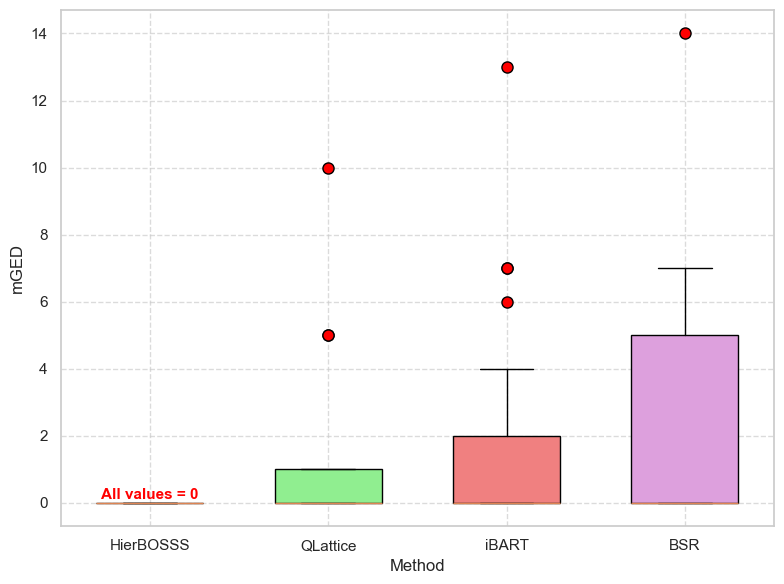

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set(style="whitegrid")

flier_props = dict(marker='o', markerfacecolor='red', markersize=8, linestyle='none')

# Create boxplot
plt.figure(figsize=(8, 6))
box = plt.boxplot([GED_HierBOSSS, GED_QLattice, GED_iBART, GED_BSR],
                  patch_artist=True,
                  labels=["HierBOSSS", "QLattice", "iBART", "BSR"],
                  widths=0.6,
                 flierprops=flier_props)

# Custom colors
colors = ['gold', 'lightgreen', 'lightcoral', 'plum']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    
    # Add annotation showing all values are zero
plt.text(1, 0.1, "All values = 0", ha='center', fontsize=11, color='red', fontweight='bold')

    
# Beautify the plot
#plt.title("Minimum GED's for HierBOSSS, QLattice, iBART, and BSR, over 25 data regenerations", fontsize=14, fontweight='bold')
plt.ylabel("mGED", fontsize=12)
plt.xlabel("Method", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [3]:
plt.gcf().set_size_inches(8, 6)  # width=8, height=6 in inches
plt.savefig("GED_Boxplot.png", dpi=300, bbox_inches='tight')

<Figure size 800x600 with 0 Axes>